# Classification of AI Scientific Publications 
The Cora dataset consists of **2708 scientific publications classified into one of seven classes**.
The citation network consists of **5278 links.**
Each publication in the dataset is described by a 0 or 1 valued word vector indicating the absence or presence of the corresponding word from the dictionary. 
The dictionary consists of **1433 unique words.**




## Graph Introduction



<center><img src="https://qjjnh3a9hpo1nukrg1fwoh71-wpengine.netdna-ssl.com/wp-content/uploads/2020/10/1_AIULNFbd0hm_jBQnh36HsA.png"/></center>
<center><img src="https://qjjnh3a9hpo1nukrg1fwoh71-wpengine.netdna-ssl.com/wp-content/uploads/2020/10/1_EzSQP50zcYL0zUyRt5ouDA.png"/></center>



In [1]:
################################### Libraries ##################################################
import torch
from torch.nn import Linear
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
import  torch_geometric.data as data
from torch_geometric.datasets import Planetoid
from torch_geometric.transforms import NormalizeFeatures , AddSelfLoops
from torch_geometric.utils.convert import from_networkx, to_networkx
import os
import numpy as np
import networkx as nx
import pandas as pd
from sklearn.metrics import *
data_dir = "C:/Users/david/Desktop/cora"
#data_dir = '/Users/davide_lupis/Desktop/cora'
import matplotlib.pyplot as plt
import seaborn as sns

#################################################################################################
def series(x,col=None):
    if col:
        return pd.Series(x[col].numpy())
    else:return pd.Series(x.numpy())

# Data Import

In [46]:
############################################ Data Collection ###################################
dataset = Planetoid(root='data/Planetoid', name='Cora', transform=None ) #NormalizeFeatures
print()
print(f'Dataset: {dataset}:')
print('======================')
print(f'Number of graphs: {len(dataset)}')
print(f'Number of features: {dataset.num_features}')
print(f'Number of classes: {dataset.num_classes}')
data = dataset[0]
#################################################################################################
data


Dataset: Cora():
Number of graphs: 1
Number of features: 1433
Number of classes: 7


Data(x=[2708, 1433], edge_index=[2, 10556], y=[2708], train_mask=[2708], val_mask=[2708], test_mask=[2708])

# Data Preprocessing

In [57]:
# convert planetoid to custom graph
Gnx = to_networkx(data)
edgelist = nx.to_pandas_edgelist(Gnx)
edgelist["relation_type"] = "cites"
vocabulary = 1433
feature_names = ["w_{}".format(i) for i in range(vocabulary)]
nodes = pd.DataFrame( data.x.numpy() , columns = feature_names ) 
nodes["subject"] = series(data.y)

# Converting string to values using label encoder since is not possible to switch from string to tensor
dictionary = { key:value for key,value in zip( nodes["subject"].unique(), np.arange(0,7))} 
nodes["train_mask"] = series(data.train_mask)
nodes["test_mask"] = series(data.test_mask)
nodes["val_mask"] = series(data.val_mask)

In [58]:
nodes.head()

,w_0,w_1,w_2,w_3,w_4,w_5,w_6,w_7,w_8,w_9,...,w_1427,w_1428,w_1429,w_1430,w_1431,w_1432,subject,train_mask,test_mask,val_mask
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,3,True,False,False
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,4,True,False,False
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,4,True,False,False
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0,True,False,False
4,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,3,True,False,False


## Boolean vector to balance training

In [59]:
nodes["subject"][nodes.train_mask].value_counts()

3    20
4    20
0    20
2    20
1    20
5    20
6    20
Name: subject, dtype: int64

In [60]:
edgelist.head()

,source,target,relation_type
0,0,633,cites
1,0,1862,cites
2,0,2582,cites
3,1,2,cites
4,1,652,cites


# GCN Layers

* What are GCN according to a Data Scientist ? 

    GCN is a type of convolutional neural network that can work directly on graphs and take advantage of their structural information.
    

* What are GCN according to a Mathematician ? 

    GCN is a localized first-order approximation of Spectral Graph Convolution.

**The general idea of GCN:**
Instead of manually creating features and use a neural network, we take advantage of the structural information using aggregation functions with the property of permutation invariance ( for example: Average or Sum).
The final vector will "summarize" all the network information, both of node features and structure.


How to achieve such results ?  **Using Matrix Multiplications as for loop system**


<center><img src="https://qjjnh3a9hpo1nukrg1fwoh71-wpengine.netdna-ssl.com/wp-content/uploads/2020/10/1_n39QwMbGc1xKjnw0V44gdg.png"/></center>



Few things to consider:


   *  In the Adjancy Matrix we miss the feature of the node itself. For example, the first row of the result matrix should contain features of node A too. This means also that the Degree Matrix will now take into account the connection with the node itself!
   * Instead of sum() function, we need to take the average, or even better, the weighted average of neighbors’ feature vectors. Why don’t we use the sum() function? The reason is that when using the sum() function, high-degree nodes are likely to have huge v vectors, while low-degree nodes tend to get small aggregate vectors, which may later cause exploding or vanishing gradients (e.g., when using sigmoid). Besides, Neural networks seem to be sensitive to the scale of input data. Thus, we need to normalize these vectors to get rid of the potential issues.


Recall the initial example of a graph



<center><img src="https://qjjnh3a9hpo1nukrg1fwoh71-wpengine.netdna-ssl.com/wp-content/uploads/2020/10/1_AIULNFbd0hm_jBQnh36HsA.png"/></center>
<center><img src="https://qjjnh3a9hpo1nukrg1fwoh71-wpengine.netdna-ssl.com/wp-content/uploads/2020/10/1_EzSQP50zcYL0zUyRt5ouDA.png"/></center>

n Problem (1), we can fix by adding an Identity matrix I to A to get a new adjacency matrix Ã.

Pick lambda = 1 (the feature of the node itself is just important as its neighbors), we have $Ã = A + I.$ 

Note that we can treat lambda as a trainable parameter, but for now, just assign the lambda to 1, and even in the paper, lambda is just simply assigned to 1.

<center><img src="https://qjjnh3a9hpo1nukrg1fwoh71-wpengine.netdna-ssl.com/wp-content/uploads/2020/10/1_juTzvQ8szBH7ovkJFErzow.png"/></center>

<center><img src="https://qjjnh3a9hpo1nukrg1fwoh71-wpengine.netdna-ssl.com/wp-content/uploads/2020/10/1_SKbO9TiIT6_yjdp30Rn7wg.png"/></center>


For matrix scaling, we usually multiply the matrix by a diagonal matrix. In this case, we want to take the average of the sum feature, or mathematically, to scale the sum vector matrix ÃX according to the node degrees. Diagonal matrix is scaled using the Degree matrix D̃ (Why D̃, not D? Because we’re considering Degree matrix D̃ of new adjacency matrix Ã, not A anymore).



<center><img src="https://qjjnh3a9hpo1nukrg1fwoh71-wpengine.netdna-ssl.com/wp-content/uploads/2020/10/1_Arx7cXRdEnnlkVP-nn3bQA.png"/></center>

By taking the multiplication of D̃ inverse and X, we can take the average of all neighbors’ feature vectors (including itself).



<center><img src="https://qjjnh3a9hpo1nukrg1fwoh71-wpengine.netdna-ssl.com/wp-content/uploads/2020/10/1_Gb2adv2hOTkJ9jv_D1XsEQ-610x206.png"></center>

**A small variation of the previous approach is to apply simmetric diagonalization using $\hat{D}^{-\frac{1}{2}}$ to create a weighted average that will give more weight to node with an higher degree.**


<center><img src="https://qjjnh3a9hpo1nukrg1fwoh71-wpengine.netdna-ssl.com/wp-content/uploads/2020/10/1__haJHwnJmov73jGNyFa3xw.png"></center>


<center><img src="https://qjjnh3a9hpo1nukrg1fwoh71-wpengine.netdna-ssl.com/wp-content/uploads/2020/10/1_KVgmKjmh2ldrN4EYAtU6GQ.png"></center>


<left><img src="https://qjjnh3a9hpo1nukrg1fwoh71-wpengine.netdna-ssl.com/wp-content/uploads/2020/10/1_TUnbMKWI0iFijJJPHwhYTQ.png"></left>



<left><img src="https://qjjnh3a9hpo1nukrg1fwoh71-wpengine.netdna-ssl.com/wp-content/uploads/2020/10/1_f5Gb9QHOrnBHHG2wSP83pg.png"></left>


# Goal: Transductive Learning Node Classification


In contrast to inductive learning, transductive learning techniques have observed all the data beforehand, both the training and testing datasets. 
We learn from the already observed training dataset and then predict the labels of the testing dataset. Even though we do not know the labels of the testing datasets, we can make use of the patterns and additional information present in this data during the learning process.

Predict the subject of a paper (node) on the basis of the surrounding node data and the structure of the graph



<center><img src="https://qjjnh3a9hpo1nukrg1fwoh71-wpengine.netdna-ssl.com/wp-content/uploads/2020/10/1_3zLYKPCtRzyr6lvj_BDUlw.png" ></center>




## Model Definition and Benchmark

In [51]:
num_classes = 7 
num_features = 1433
##################################### Model and Data Preparation ##########################################
class MLP(torch.nn.Module):
    def __init__(self, hidden_channels):
        super().__init__()
        torch.manual_seed(12345)
        self.lin1 = Linear(num_features, hidden_channels)
        self.lin2 = Linear(hidden_channels, num_classes)
    def forward(self, x):
        x = self.lin1(x)
        x = x.relu()
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.lin2(x)
        return x

class GCN(torch.nn.Module):
    def __init__(self, hidden_channels):
        super().__init__()
        torch.manual_seed(12345)
        self.conv1 = GCNConv(num_features, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, num_classes)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = x.relu()
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.conv2(x, edge_index)
        return x

# How do we choose the dimension of the hidden layers ?
# There is no way of knowing in advance, the main idea is that we should reduce the dimensions  and iterate
# In literature they propose 16 as the best number of hidden layers
n_hidden_dim = 16
#################################################################################################


################################## MLP  ########################################################
# Use MLP model as model
model = MLP(hidden_channels=n_hidden_dim)
# Define loss criterion.

from sklearn.utils.class_weight import  compute_class_weight

class_weights = compute_class_weight(class_weight='balanced',
                                     classes= np.unique(nodes["subject"].map(dictionary).unique()),
                                     y= series(data.y)
                                    )

# Possible Option is weights
weights= torch.tensor(class_weights,dtype=torch.float)
#criterion  = torch.nn.NLLLoss(weight=weights) 
# Cross Entropy Loss : 
# https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html
criterion = torch.nn.CrossEntropyLoss(weight=None)

The Loss function is simply calculated by the cross-entropy error over all labeled examples, where $Y_{l}$ is the set of node indices that have labels.


<center><img src="https://qjjnh3a9hpo1nukrg1fwoh71-wpengine.netdna-ssl.com/wp-content/uploads/2020/10/1_mOc1br89ryhoE_QenPttxg-610x194.png"></center>

## Model Training

In [51]:
# Define Optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)  # Define optimizer.
print(model)
def train():
      # Train option
      model.train()
      # Clear gradients.
      optimizer.zero_grad()
      # Perform a single forward pass for the iteration i
      out = model(data.x)
      # Compute the loss solely based on the training nodes. 
      loss = criterion(out[data.train_mask], data.y[data.train_mask])
      # Derive gradients.
      loss.backward()
      # Update parameters based on gradients.
      optimizer.step()
      return loss

def test():
      # Model is in evaluation mode
      model.eval()
      # Use model to make prediction
      out = model(data.x)
      # Use the class with highest probability since the output is a vector of softmax
      pred = out.argmax(dim=1)
      # Compute accuracy as the counter of  prediction vs ground-truth labels.
      test_correct = pred[data.test_mask] == data.y[data.test_mask]
      # Derive ratio of correct predictions. to get Accuracy
      test_acc = int(test_correct.sum()) / int(data.test_mask.sum())
      return test_acc, pred

for epoch in range(1, 201):
    loss = train()
    #print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}')
test_acc_mlp,pred_mlp = test()
pred_mlp = series(pred_mlp,None)
print(f'Test Accuracy MLP: {test_acc_mlp:.4f}')
#################################################################################################


################################## Graph Convolution ############################################
# Use Graph Convolutional Layers
model = GCN(hidden_channels=n_hidden_dim)
print(model)
# Define Adam as optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)
# Define loss criterion.
criterion = torch.nn.CrossEntropyLoss()
def train():
    # Training mode
    model.train()
    # Clear gradients.
    optimizer.zero_grad()
    # Perform a single forward pass for this iteration, note that edges are also an argument here
    out = model(data.x, data.edge_index)
    # Compute the loss solely based on the training nodes
    loss = criterion(out[data.train_mask],
                     data.y[data.train_mask])
    # Derive gradients.
    loss.backward()
    # Update parameters based on gradients.
    optimizer.step()
    return loss

def test():
    # Evaluation mode
    model.eval()
    # Compute predictions as output of model
    out = model(data.x, data.edge_index)
    # Use the class with highest probability since the output is a vector of softmax
    pred = out.argmax(dim=1)
    # Compute accuracy as the counter of  prediction vs ground-truth labels.
    test_correct = pred[data.test_mask] == data.y[data.test_mask]
    # Derive ratio of correct predictions. to get Accuracy
    test_acc = int(test_correct.sum()) / int(data.test_mask.sum())
    return test_acc,pred

for epoch in range(1, 101):
    loss = train()
    #print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}')

test_acc_gcn ,pred_gcn = test()
pred_gcn = series(pred_gcn,None)
print(f'Test Accuracy with GCN: {test_acc_gcn:.4f}')

MLP(
  (lin1): Linear(in_features=1433, out_features=16, bias=True)
  (lin2): Linear(in_features=16, out_features=7, bias=True)
)
Test Accuracy MLP: 0.4990
GCN(
  (conv1): GCNConv(1433, 16)
  (conv2): GCNConv(16, 7)
)
Test Accuracy with GCN: 0.7910


              precision    recall  f1-score   support

           0       0.46      0.47      0.46       130
           1       0.37      0.78      0.50        91
           2       0.54      0.67      0.59       144
           3       0.84      0.26      0.39       319
           4       0.47      0.73      0.58       149
           5       0.61      0.43      0.50       103
           6       0.38      0.56      0.45        64

    accuracy                           0.50      1000
   macro avg       0.52      0.56      0.50      1000
weighted avg       0.59      0.50      0.48      1000



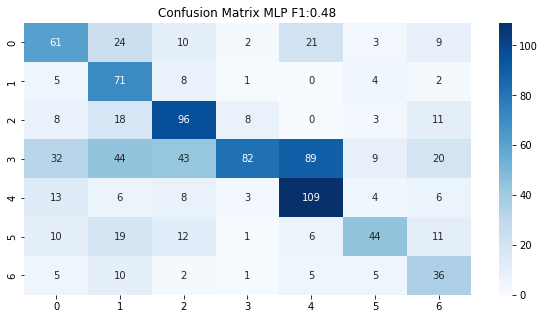

In [66]:
y_pred  = pred_mlp[series(data.test_mask)]
y_true = series(data.y[data.test_mask])
# Display CM
figure = plt.figure(figsize = (10,5))
print(classification_report(y_true, y_pred))
ax= figure.add_subplot()
f1_mlp = f1_score(y_true, y_pred,average="weighted").round(2)
sns.heatmap(confusion_matrix(y_true, y_pred), annot=True, fmt='g', ax=ax,cmap = "Blues").set_title(f"Confusion Matrix MLP F1:{f1_mlp}");

              precision    recall  f1-score   support

           0       0.61      0.78      0.69       130
           1       0.78      0.85      0.81        91
           2       0.87      0.92      0.89       144
           3       0.94      0.69      0.80       319
           4       0.73      0.87      0.80       149
           5       0.78      0.74      0.76       103
           6       0.74      0.83      0.78        64

    accuracy                           0.79      1000
   macro avg       0.78      0.81      0.79      1000
weighted avg       0.81      0.79      0.79      1000



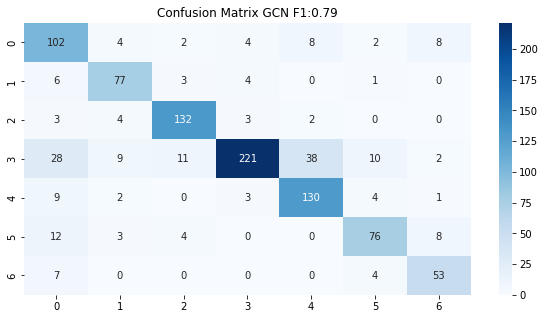

In [67]:
y_pred  = pred_gcn[series(data.test_mask)]
y_true = series(data.y[data.test_mask])
# Display CM
figure = plt.figure(figsize = (10,5))
print(classification_report(y_true, y_pred))
ax= figure.add_subplot()
f1_gcn = f1_score(y_true, y_pred,average="micro").round(2)
sns.heatmap(confusion_matrix(y_true, y_pred), annot=True, fmt='g', ax=ax,cmap = "Blues").set_title(f"Confusion Matrix GCN F1:{f1_gcn}");

# References

* Semi-Supervised Classification with Graph Convolutional Networks: https://arxiv.org/abs/1609.02907

* Graph Convolutional Layers : https://tkipf.github.io/graph-convolutional-networks/

* Graph Datasets : https://linqs.soe.ucsc.edu/data

* Introdocution to Graph Neural Networks: https://towardsdatascience.com/a-gentle-introduction-to-graph-neural-network-basics-deepwalk-and-graphsage-db5d540d50b3

* PyTorch Geometric Documentation : https://pytorch-geometric.readthedocs.io/en/latest/index.html

* Machine Learning with Graph : https://www.youtube.com/playlist?list=PLoROMvodv4rPLKxIpqhjhPgdQy7imNkDn

* Graph Convolutional Networks (GCN) : https://www.topbots.com/graph-convolutional-networks/

* Inductive vs. Transductive Learning: https://towardsdatascience.com/inductive-vs-transductive-learning-e608e786f7d

* A Review : Graph Convolutional Networks (GCN): https://dsgiitr.com/blogs/gcn/